# 卷积神经网络（LeNet）
:label:`sec_lenet`

我们现在拥有了组装一个功能齐全的CNN所需的所有要素。在我们早期处理图像数据时，我们对Fashion-MNIST数据集中的服装图片应用了带有softmax回归的线性模型（:numref:`sec_softmax_scratch`）和一个多层感知机（:numref:`sec_mlp-implementation`）。为了使这些数据变得易于处理，我们首先将每张$28\times28$的图像展平为固定长度的784维向量，并在此后通过全连接层进行处理。现在既然我们掌握了卷积层，就可以保持图像的空间结构。此外，用卷积层代替全连接层的一个额外好处是，我们将拥有更简洁的模型，这些模型所需的参数大大减少。

在本节中，我们将介绍*LeNet*，这是最早发布的、因其在计算机视觉任务上的表现而受到广泛关注的CNN之一。该模型由当时在AT&T贝尔实验室工作的研究员Yann LeCun提出并以其名字命名，目的是识别图像中的手写数字 :cite:`LeCun.Bottou.Bengio.ea.1998`。这项工作代表了十年来发展这项技术的研究成果；LeCun的团队发表了首个成功通过反向传播训练CNN的研究 :cite:`LeCun.Boser.Denker.ea.1989`。

当时LeNet取得了出色的结果，其性能与支持向量机相当，后者当时是监督学习的主要方法之一，达到了每数字错误率低于1%的成绩。最终，LeNet被调整用于识别ATM机处理存款时的数字。直到今天，一些ATM机仍在运行Yann LeCun和他的同事Léon Bottou在20世纪90年代编写的代码！

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## LeNet

在高层次上，（**LeNet (LeNet-5) 包含两部分：
(i) 一个由两个卷积层组成的卷积编码器；和
(ii) 一个由三个全连接层组成的密集块**）。
架构总结见 :numref:`img_lenet`。

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](../img/lenet.svg)
:label:`img_lenet`

每个卷积块的基本单元是一个卷积层、一个 Sigmoid 激活函数和随后的平均池化操作。
请注意，虽然 ReLU 和最大池化效果更好，但当时尚未被发现。
每个卷积层使用 $5\times 5$ 的内核和 Sigmoid 激活函数。
这些层将空间排列的输入映射到多个二维特征图，通常会增加通道数。
第一个卷积层有 6 个输出通道，而第二个有 16 个。
每个 $2\times2$ 的池化操作（步幅为 2）通过空间下采样将维度减少 4 倍。
卷积块输出的形状为（批量大小，通道数，高度，宽度）。

为了将卷积块的输出传递给密集块，
我们必须将小批量中的每个样本展平。
换句话说，我们将这个四维输入转换成全连接层期望的二维输入：
提醒一下，我们希望得到的二维表示使用第一维来索引小批量中的样本，并使用第二维给出每个样本的扁平向量表示。
LeNet 的密集块有三个全连接层，分别有 120、84 和 10 个输出。
因为我们仍在进行分类，所以 10 维输出层对应于可能的输出类别数量。

尽管真正理解 LeNet 内部的工作原理可能需要一些努力，
但我们希望以下代码片段能说服你，
用现代深度学习框架实现这样的模型是非常简单的。
我们只需要实例化一个 `Sequential` 块，并将适当的层链接在一起，
使用如 :numref:`subsec_xavier` 中介绍的 Xavier 初始化。

In [2]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [3]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

我们在重现LeNet时做了一些改动，特别是将高斯激活层替换为了softmax层。这极大地简化了实现，尤其是因为现在很少使用高斯解码器。除此之外，这个网络与原始的LeNet-5架构相匹配。

让我们看看网络内部发生了什么。通过将单通道（黑白）
$28 \times 28$ 图像输入网络
并在每一层打印输出形状，
我们可以[**检查模型**]以确保
其操作与 :numref:`img_lenet_vert` 中的预期一致。

![压缩表示的LeNet-5。](../img/lenet-vert.svg)
:label:`img_lenet_vert`

In [4]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


请注意，卷积块中每一层的表示的高度和宽度
都比前一层有所减少。
第一个卷积层使用了两像素的填充
来补偿使用$5 \times 5$内核导致的高度和宽度的减少。
顺便提一下，原始MNIST OCR数据集中的$28 \times 28$像素图像尺寸是通过从原本测量为$32 \times 32$像素的原始扫描件中*裁剪*掉两行（及列）像素得到的。这样做主要是为了节省空间（减少了30%），在当时兆字节非常宝贵。

相比之下，第二个卷积层没有使用填充，
因此高度和宽度各自减少了四个像素。
随着层数的增加，
通道数量逐层增加
从输入时的1个到第一个卷积层后的6个
再到第二个卷积层后的16个。
然而，每个池化层都将高度和宽度减半。
最后，每个全连接层都会降低维度，
最终输出的维度与类别的数量相匹配。


## 训练

现在我们已经实现了模型，
让我们[**运行一个实验来看看LeNet-5模型在Fashion-MNIST上的表现如何**]。

虽然CNN的参数较少，
但由于每个参数参与了更多的乘法运算，
它们的计算成本仍然可能高于深度相似的多层感知机(MLP)。
如果你有GPU的话，这可能是加速训练的好时机。
请注意，
`d2l.Trainer`类处理了所有细节。
默认情况下，它会在可用设备上初始化模型参数。
就像对于MLP一样，我们的损失函数是交叉熵，
并通过小批量随机梯度下降来最小化它。

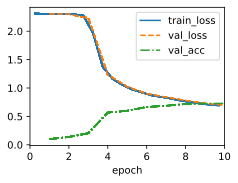

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 摘要

我们在本章取得了显著的进展。我们从20世纪80年代的多层感知机（MLPs）过渡到了90年代和21世纪初的卷积神经网络（CNNs）。例如LeNet-5这样的架构至今仍然具有重要意义。值得将LeNet-5在Fashion-MNIST上的错误率与使用MLPs所能达到的最佳结果(:numref:`sec_mlp-implementation`)以及更先进的架构如ResNet(:numref:`sec_resnet`)进行比较。LeNet与后者更为相似。正如我们将看到的，主要的区别之一是更大的计算量使得实现更复杂的架构成为可能。

第二个区别是我们能够相对容易地实现LeNet。过去需要花费数月时间用C++和汇编代码进行工程优化、改进SN（一个早期基于Lisp的深度学习工具）:cite:`Bottou.Le-Cun.1988`，以及对模型进行实验，现在可以在几分钟内完成。正是这种令人难以置信的生产力提升极大地民主化了深度学习模型的开发。在下一章中，我们将深入探讨这一领域，看看它会带我们去哪里。

## 练习

1. 让我们现代化LeNet。实现并测试以下更改：
    1. 将平均池化替换为最大池化。
    1. 将softmax层替换为ReLU。
1. 除了最大池化和ReLU之外，尝试改变LeNet风格网络的大小以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道数量。
    1. 调整卷积层数量。
    1. 调整全连接层数量。
    1. 调整学习率和其他训练细节（例如，初始化和训练周期数）。
1. 在原始MNIST数据集上尝试改进后的网络。
1. 显示LeNet第一层和第二层对于不同输入（例如，毛衣和外套）的激活情况。
1. 当你向网络输入明显不同的图像时（例如，猫、汽车或随机噪声），激活情况会发生什么变化？

[讨论](https://discuss.d2l.ai/t/74)